In [52]:
%pip install ipywidgets fuzzywuzzy python-Levenshtein

import pandas as pd
import numpy as np
from io import StringIO
import ipywidgets as widgets
from IPython.display import display
from fuzzywuzzy import fuzz
from itertools import product


Note: you may need to restart the kernel to use updated packages.


In [53]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from io import BytesIO

# Create two FileUpload widgets to accept XLSX files
uploader1 = widgets.FileUpload(
    accept='.xlsx',  # only allow XLSX
    multiple=False
)
uploader2 = widgets.FileUpload(
    accept='.xlsx',
    multiple=False
)

print("Upload first XLSX file:")
display(uploader1)
print("\nUpload second XLSX file:")
display(uploader2)

# A button to trigger reading the files into DataFrames.
button_load = widgets.Button(description="Load DataFrames")
display(button_load)

# We'll store the DataFrames globally (df1, df2) so subsequent cells can use them.
df1 = None
df2 = None

def load_datasets(file_upload_widget):
    """
    Takes a FileUpload widget, reads the (single) uploaded XLSX,
    and returns a pandas DataFrame. Returns None if no file is uploaded.
    """
    if len(file_upload_widget.value) == 0:
        return None
    # There's only one file in 'value' because multiple=False
    uploaded_file = next(iter(file_upload_widget.value.values()))
    content = uploaded_file['content']
    
    # Read the in-memory content as Excel
    df = pd.read_excel(BytesIO(content))
    return df

def on_button_load_clicked(b):
    global df1, df2
    df1 = load_datasets(uploader1)
    df2 = load_datasets(uploader2)
    
    if df1 is not None and df2 is not None:
        print("DataFrames loaded successfully!")
        print("\nFirst few rows of df1:")
        display(df1.head())
        print("\nFirst few rows of df2:")
        display(df2.head())
    else:
        print("Please upload both XLSX files before clicking 'Load DataFrames'.")

button_load.on_click(on_button_load_clicked)


Upload first XLSX file:


FileUpload(value={}, accept='.xlsx', description='Upload')


Upload second XLSX file:


FileUpload(value={}, accept='.xlsx', description='Upload')

Button(description='Load DataFrames', style=ButtonStyle())

DataFrames loaded successfully!

First few rows of df1:


,Transaction Date,Description,Currency,Credit,Debit,Balance
0,2023.09.01,IN080,LKR,48000.0,NaN,1607800
1,2023.09.01,Salaries for employess,LKR,NaN,500000.0,1107800
2,2023.09.02,Sales Revenue for Bulk of Boxes (IN094),LKR,956000.0,NaN,2063800
3,2023.09.02,Sales Revenue for Bulk of Bottles(IN068),LKR,785000.0,NaN,2848800
4,2023.09.02,Tranportation Chargers,LKR,NaN,12530.0,2836270



First few rows of df2:


,Transaction Date,Description,Currency,Credit,Debit,Balance
0,2023.09.01,IN080,LKR,48000.0,NaN,1607800
1,2023.09.01,Salaries for employess,LKR,NaN,500000.0,1107800
2,2023.09.02,Sales Revenue for Bulk of Boxes (IN094),LKR,956000.0,NaN,2063800
3,2023.09.02,Sales Revenue for Bulk of Bottles(IN068),LKR,785000.0,NaN,2848800
4,2023.09.02,Tranportation Chargers,LKR,NaN,12530.0,2836270


In [54]:
# We’ll attempt to match columns from df1 to df2 by name using fuzzy matching.

button_match = widgets.Button(description="Fuzzy Match Columns")
display(button_match)

col_matches = {}  # dict to store best match from df2 for each column in df1

def match_columns_fuzzy(list1, list2, threshold=60):
    """
    For each column in list1, find the best fuzzy match in list2.
    If the best score >= threshold, return that match; else return None.
    """
    matched = {}
    for c1 in list1:
        best_match = None
        best_score = -1
        for c2 in list2:
            score = fuzz.ratio(c1.lower(), c2.lower())
            if score > best_score:
                best_score = score
                best_match = c2
        if best_score >= threshold:
            matched[c1] = best_match
        else:
            matched[c1] = None
    return matched

def on_button_match_clicked(b):
    global col_matches
    if df1 is None or df2 is None:
        print("DataFrames not loaded yet. Please load them first.")
        return
    
    col_matches = match_columns_fuzzy(df1.columns, df2.columns, threshold=60)
    print("Fuzzy matched columns (df1 -> df2):")
    for c1, c2 in col_matches.items():
        print(f"  {c1} -> {c2}  (None means no match above threshold)")

button_match.on_click(on_button_match_clicked)


Button(description='Fuzzy Match Columns', style=ButtonStyle())

Fuzzy matched columns (df1 -> df2):
  Transaction Date -> Transaction Date  (None means no match above threshold)
  Description -> Description  (None means no match above threshold)
  Currency -> Currency  (None means no match above threshold)
  Credit -> Credit  (None means no match above threshold)
  Debit -> Debit  (None means no match above threshold)
  Balance -> Balance  (None means no match above threshold)


In [55]:
button_guess_roles = widgets.Button(description="Guess Column Roles")
display(button_guess_roles)

col_roles = {}  # dict to store "role" of each df1 column (date, text, numeric, ignore, etc.)

def guess_column_roles(df, col_matches):
    """
    Simple heuristic to guess whether a column is date, text, or numeric 
    based on the combined name of df1_column + matched df2_column.
    """
    roles = {}
    for c1, c2 in col_matches.items():
        if c2 is None:
            roles[c1] = 'ignore'
            continue
        
        combined_name = (c1 + c2).lower()
        
        if 'date' in combined_name:
            roles[c1] = 'date'
        elif any(x in combined_name for x in ['desc', 'memo', 'text']):
            roles[c1] = 'text'
        elif any(x in combined_name for x in ['amount','debit','credit','balance','amt']):
            roles[c1] = 'numeric'
        else:
            # default to 'ignore' if uncertain
            roles[c1] = 'ignore'
    return roles

def on_guess_roles_clicked(b):
    global col_roles
    if df1 is None or df2 is None:
        print("DataFrames not loaded yet.")
        return
    if not col_matches:
        print("No column matches found. Run fuzzy match first.")
        return
    
    col_roles = guess_column_roles(df1, col_matches)
    print("Guessed column roles:")
    for c1 in col_roles:
        c2 = col_matches[c1]
        print(f"  {c1} -> {c2} : {col_roles[c1]}")

button_guess_roles.on_click(on_guess_roles_clicked)


Button(description='Guess Column Roles', style=ButtonStyle())

Guessed column roles:
  Transaction Date -> Transaction Date : date
  Description -> Description : text
  Currency -> Currency : ignore
  Credit -> Credit : numeric
  Debit -> Debit : numeric
  Balance -> Balance : numeric


In [56]:
button_create_pairs = widgets.Button(description="Create Pairs")
display(button_create_pairs)

pairs = None

def on_create_pairs_clicked(b):
    global pairs
    if df1 is None or df2 is None:
        print("DataFrames not loaded yet.")
        return
    if not col_matches:
        print("No column matches found.")
        return
    if not col_roles:
        print("Column roles not determined.")
        return
    
    # Generate all pairs of rows from df1 and df2
    pairs_list = list(product(df1.index, df2.index))
    
    # For each pair, create a dict of matched columns
    data_for_pairs = []
    for (i, j) in pairs_list:
        row1 = df1.loc[i]
        row2 = df2.loc[j]
        row_dict = {}
        # add the raw columns
        for c1, c2 in col_matches.items():
            if c2 is None:
                continue
            val1 = row1[c1]
            val2 = row2[c2]
            row_dict[f'df1_{c1}'] = val1
            row_dict[f'df2_{c2}'] = val2
        data_for_pairs.append(row_dict)
    
    pairs = pd.DataFrame(data_for_pairs)
    print("Pairs created. Here is a preview:")
    display(pairs.head(10))

button_create_pairs.on_click(on_create_pairs_clicked)


Button(description='Create Pairs', style=ButtonStyle())

Pairs created. Here is a preview:


,df1_Transaction Date,df2_Transaction Date,df1_Description,df2_Description,df1_Currency,df2_Currency,df1_Credit,df2_Credit,df1_Debit,df2_Debit,df1_Balance,df2_Balance
0,2023.09.01,2023.09.01,IN080,IN080,LKR,LKR,48000.0,48000.0,NaN,NaN,1607800,1607800
1,2023.09.01,2023.09.01,IN080,Salaries for employess,LKR,LKR,48000.0,NaN,NaN,500000.0,1607800,1107800
2,2023.09.01,2023.09.02,IN080,Sales Revenue for Bulk of Boxes (IN094),LKR,LKR,48000.0,956000.0,NaN,NaN,1607800,2063800
3,2023.09.01,2023.09.02,IN080,Sales Revenue for Bulk of Bottles(IN068),LKR,LKR,48000.0,785000.0,NaN,NaN,1607800,2848800
4,2023.09.01,2023.09.02,IN080,Tranportation Chargers,LKR,LKR,48000.0,NaN,NaN,12530.0,1607800,2836270
5,2023.09.01,2023.09.03,IN080,Sales Revenue for 5 boxes(IN078),LKR,LKR,48000.0,368400.0,NaN,NaN,1607800,3204670
6,2023.09.01,2023.09.03,IN080,Elecrticity Bill,LKR,LKR,48000.0,NaN,NaN,16000.0,1607800,3188670
7,2023.09.01,2023.09.04,IN080,Water Bill,LKR,LKR,48000.0,NaN,NaN,24000.0,1607800,3164670
8,2023.09.01,2023.09.04,IN080,Sales Revenue for Bulk of Boxes(IN105),LKR,LKR,48000.0,1960000.0,NaN,NaN,1607800,5124670
9,2023.09.01,2023.09.04,IN080,Telephone Bills,LKR,LKR,48000.0,NaN,NaN,25900.0,1607800,5098770


In [57]:
button_compute_features = widgets.Button(description="Compute Features")
display(button_compute_features)

def on_compute_features_clicked(b):
    global pairs
    if pairs is None:
        print("Pairs DataFrame is not created yet.")
        return
    
    for c1, role in col_roles.items():
        c2 = col_matches[c1]
        if c2 is None:
            continue
        
        col_df1 = f'df1_{c1}'
        col_df2 = f'df2_{c2}'
        
        if role == 'date':
            # Convert to datetime, compute days difference
            pairs[col_df1] = pd.to_datetime(pairs[col_df1], errors='coerce')
            pairs[col_df2] = pd.to_datetime(pairs[col_df2], errors='coerce')
            diff_col = f'{c1}_diff'
            pairs[diff_col] = (pairs[col_df1] - pairs[col_df2]).abs().dt.days
            
        elif role == 'text':
            # Use fuzzy similarity
            sim_col = f'{c1}_sim'
            pairs[sim_col] = pairs.apply(
                lambda row: fuzz.ratio(str(row[col_df1]), str(row[col_df2])) 
                            if pd.notnull(row[col_df1]) and pd.notnull(row[col_df2]) else 0,
                axis=1
            )
            
        elif role == 'numeric':
            # Convert to float, compute absolute difference
            diff_col = f'{c1}_diff'
            pairs[diff_col] = (pairs[col_df1].astype(float) - pairs[col_df2].astype(float)).abs()
            
        else:
            # ignore
            pass
    
    print("Features computed. Columns ending with _diff or _sim were added.")
    display(pairs.head(10))

button_compute_features.on_click(on_compute_features_clicked)


Button(description='Compute Features', style=ButtonStyle())

Features computed. Columns ending with _diff or _sim were added.


,df1_Transaction Date,df2_Transaction Date,df1_Description,df2_Description,df1_Currency,df2_Currency,df1_Credit,df2_Credit,df1_Debit,df2_Debit,df1_Balance,df2_Balance,Transaction Date_diff,Description_sim,Credit_diff,Debit_diff,Balance_diff
0,2023-09-01,2023-09-01,IN080,IN080,LKR,LKR,48000.0,48000.0,NaN,NaN,1607800,1607800,0,100,0.0,NaN,0.0
1,2023-09-01,2023-09-01,IN080,Salaries for employess,LKR,LKR,48000.0,NaN,NaN,500000.0,1607800,1107800,0,0,NaN,NaN,500000.0
2,2023-09-01,2023-09-02,IN080,Sales Revenue for Bulk of Boxes (IN094),LKR,LKR,48000.0,956000.0,NaN,NaN,1607800,2063800,1,14,908000.0,NaN,456000.0
3,2023-09-01,2023-09-02,IN080,Sales Revenue for Bulk of Bottles(IN068),LKR,LKR,48000.0,785000.0,NaN,NaN,1607800,2848800,1,18,737000.0,NaN,1241000.0
4,2023-09-01,2023-09-02,IN080,Tranportation Chargers,LKR,LKR,48000.0,NaN,NaN,12530.0,1607800,2836270,1,0,NaN,NaN,1228470.0
5,2023-09-01,2023-09-03,IN080,Sales Revenue for 5 boxes(IN078),LKR,LKR,48000.0,368400.0,NaN,NaN,1607800,3204670,2,21,320400.0,NaN,1596870.0
6,2023-09-01,2023-09-03,IN080,Elecrticity Bill,LKR,LKR,48000.0,NaN,NaN,16000.0,1607800,3188670,2,0,NaN,NaN,1580870.0
7,2023-09-01,2023-09-04,IN080,Water Bill,LKR,LKR,48000.0,NaN,NaN,24000.0,1607800,3164670,3,0,NaN,NaN,1556870.0
8,2023-09-01,2023-09-04,IN080,Sales Revenue for Bulk of Boxes(IN105),LKR,LKR,48000.0,1960000.0,NaN,NaN,1607800,5124670,3,14,1912000.0,NaN,3516870.0
9,2023-09-01,2023-09-04,IN080,Telephone Bills,LKR,LKR,48000.0,NaN,NaN,25900.0,1607800,5098770,3,0,NaN,NaN,3490970.0


In [58]:
import ipywidgets as widgets
from IPython.display import display

button_thresholds = widgets.Button(description="Build Threshold Inputs")
button_apply_thresholds = widgets.Button(description="Apply Thresholds")

# We'll place the threshold widgets in a dictionary, keyed by column name.
threshold_widgets = {}
threshold_inputs = {}  # final threshold values get stored here after user clicks "Apply Thresholds"

box_thresholds = widgets.VBox()  # container to display all threshold widgets
display(button_thresholds, button_apply_thresholds, box_thresholds)

def build_threshold_widgets():
    """
    Looks at the 'pairs' DataFrame columns to see which columns end in _diff or _sim,
    then builds an appropriate ipywidget for each so the user can input thresholds.
    """
    global threshold_widgets

    if pairs is None:
        print("Pairs not created yet. Make sure to generate 'pairs' first.")
        return

    # Clear any existing widgets from previous runs
    threshold_widgets.clear()
    box_thresholds.children = []

    # Identify diff vs sim columns
    diff_cols = [c for c in pairs.columns if c.endswith('_diff')]
    sim_cols  = [c for c in pairs.columns if c.endswith('_sim')]

    # For each _diff column, we typically want a "max difference" threshold,
    # so we can start with a default float, say 10.0
    for col in diff_cols:
        txt = widgets.FloatText(
            value=10.0,
            description=f"{col}:",
            disabled=False
        )
        threshold_widgets[col] = txt

    # For each _sim column, we typically want a "min similarity" threshold,
    # so default might be 60.0
    for col in sim_cols:
        txt = widgets.FloatText(
            value=60.0,
            description=f"{col}:",
            disabled=False
        )
        threshold_widgets[col] = txt

    # Put all threshold widgets in a vertical layout
    box_thresholds.children = list(threshold_widgets.values())

def on_button_thresholds_clicked(b):
    build_threshold_widgets()

def on_button_apply_thresholds_clicked(b):
    """
    Reads the current values from all threshold widgets into 'threshold_inputs'.
    """
    if not threshold_widgets:
        print("No threshold widgets to apply. Click 'Build Threshold Inputs' first.")
        return
    threshold_inputs.clear()
    for col, widget_obj in threshold_widgets.items():
        threshold_inputs[col] = widget_obj.value

    print("Thresholds saved to 'threshold_inputs':")
    for col, val in threshold_inputs.items():
        print(f"  {col} = {val}")

button_thresholds.on_click(on_button_thresholds_clicked)
button_apply_thresholds.on_click(on_button_apply_thresholds_clicked)


Button(description='Build Threshold Inputs', style=ButtonStyle())

Button(description='Apply Thresholds', style=ButtonStyle())

VBox()

Thresholds saved to 'threshold_inputs':
  Transaction Date_diff = 4.0
  Credit_diff = 10.0
  Debit_diff = 10.0
  Balance_diff = 10.0
  Description_sim = 60.0


In [59]:
button_label = widgets.Button(description="Label Pairs")
display(button_label)

def on_button_label_clicked(b):
    """
    1) Checks if 'pairs' DataFrame exists (pairs is not None).
    2) Checks if threshold_inputs is populated (the dictionary created after setting thresholds).
    3) Iterates over each row in 'pairs':
       - For each feature column in threshold_inputs:
         * If it's a '_diff' column, the threshold is the maximum allowed difference.
           => 'violation' is True if row[col] > threshold.
         * If it's a '_sim' column, the threshold is the minimum required similarity.
           => 'violation' is True if row[col] < threshold.
       - If any column is in violation, label=1, else label=0.
    4) Stores these labels in a new 'label' column in 'pairs'.
    5) Shows the updated DataFrame with 'label'.
    """
    if pairs is None:
        print("Pairs not created yet.")
        return
    if not threshold_inputs:
        print("No thresholds set. Please set the thresholds first.")
        return
    
    labels = []
    for idx, row in pairs.iterrows():
        violation = False
        # Check each threshold
        for col, thr in threshold_inputs.items():
            val = row[col]
            if col.endswith('_diff'):
                # violation if the difference exceeds the threshold
                if val > thr:
                    violation = True
                    break
            elif col.endswith('_sim'):
                # violation if the similarity is below the threshold
                if val < thr:
                    violation = True
                    break
        
        # 1 if violation, else 0
        labels.append(1 if violation else 0)
    
    pairs['label'] = labels
    print("'label' column created. 1 = violates threshold(s), 0 = within thresholds.")
    display(pairs.head(20))

button_label.on_click(on_button_label_clicked)


Button(description='Label Pairs', style=ButtonStyle())

'label' column created. 1 = violates threshold(s), 0 = within thresholds.


,df1_Transaction Date,df2_Transaction Date,df1_Description,df2_Description,df1_Currency,df2_Currency,df1_Credit,df2_Credit,df1_Debit,df2_Debit,df1_Balance,df2_Balance,Transaction Date_diff,Description_sim,Credit_diff,Debit_diff,Balance_diff,label
0,2023-09-01,2023-09-01,IN080,IN080,LKR,LKR,48000.0,48000.0,NaN,NaN,1607800,1607800,0,100,0.0,NaN,0.0,0
1,2023-09-01,2023-09-01,IN080,Salaries for employess,LKR,LKR,48000.0,NaN,NaN,500000.0,1607800,1107800,0,0,NaN,NaN,500000.0,1
2,2023-09-01,2023-09-02,IN080,Sales Revenue for Bulk of Boxes (IN094),LKR,LKR,48000.0,956000.0,NaN,NaN,1607800,2063800,1,14,908000.0,NaN,456000.0,1
3,2023-09-01,2023-09-02,IN080,Sales Revenue for Bulk of Bottles(IN068),LKR,LKR,48000.0,785000.0,NaN,NaN,1607800,2848800,1,18,737000.0,NaN,1241000.0,1
4,2023-09-01,2023-09-02,IN080,Tranportation Chargers,LKR,LKR,48000.0,NaN,NaN,12530.0,1607800,2836270,1,0,NaN,NaN,1228470.0,1
5,2023-09-01,2023-09-03,IN080,Sales Revenue for 5 boxes(IN078),LKR,LKR,48000.0,368400.0,NaN,NaN,1607800,3204670,2,21,320400.0,NaN,1596870.0,1
6,2023-09-01,2023-09-03,IN080,Elecrticity Bill,LKR,LKR,48000.0,NaN,NaN,16000.0,1607800,3188670,2,0,NaN,NaN,1580870.0,1
7,2023-09-01,2023-09-04,IN080,Water Bill,LKR,LKR,48000.0,NaN,NaN,24000.0,1607800,3164670,3,0,NaN,NaN,1556870.0,1
8,2023-09-01,2023-09-04,IN080,Sales Revenue for Bulk of Boxes(IN105),LKR,LKR,48000.0,1960000.0,NaN,NaN,1607800,5124670,3,14,1912000.0,NaN,3516870.0,1
9,2023-09-01,2023-09-04,IN080,Telephone Bills,LKR,LKR,48000.0,NaN,NaN,25900.0,1607800,5098770,3,0,NaN,NaN,3490970.0,1


In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
from IPython.display import display

button_train_model = widgets.Button(description="Train RandomForest Model")
display(button_train_model)

def on_button_train_model_clicked(b):
    """
    1) Checks if 'pairs' exists and has a 'label' column.
    2) Identifies numeric feature columns (e.g., *_diff or *_sim).
    3) Splits into train/test sets.
    4) Trains a RandomForestClassifier.
    5) Prints accuracy on the test set.
    """
    if pairs is None:
        print("No 'pairs' DataFrame found. Please create and label pairs first.")
        return
    
    if 'label' not in pairs.columns:
        print("No 'label' column found in 'pairs'. Please run the labeling step.")
        return
    
    # Identify numeric feature columns that might be relevant for modeling
    feature_cols = [col for col in pairs.columns 
                    if (col.endswith('_diff') or col.endswith('_sim')) 
                       and pd.api.types.is_numeric_dtype(pairs[col])]
    
    if not feature_cols:
        print("No numeric feature columns (*_diff or *_sim) found to train on.")
        return

    X = pairs[feature_cols]
    y = pairs['label'].astype(int)

    # Split data into training and test sets (80% / 20%)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train a RandomForest model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate on test set
    accuracy = model.score(X_test, y_test)
    print(f"RandomForest model trained. Test accuracy: {accuracy:.3f}")
    
    # Optionally, store model and splits globally for reuse:
    global trained_model, X_train_global, X_test_global, y_train_global, y_test_global
    trained_model = model
    X_train_global, X_test_global = X_train, X_test
    y_train_global, y_test_global = y_train, y_test

button_train_model.on_click(on_button_train_model_clicked)


Button(description='Train RandomForest Model', style=ButtonStyle())

RandomForest model trained. Test accuracy: 1.000


Button(description='Compute SHAP Explanations', style=ButtonStyle())

Trained RandomForest. Test accuracy: 1.000


 99%|===================| 78210/78856 [00:18<00:00]        

Down-sampling from 39428 to 200 for plotting.
shap_values_to_plot.values.shape: (200, 2)
shap_values_to_plot.data.shape: (200, 2)
Feature names: ['Transaction Date_diff', 'Description_sim']

(A) SHAP Summary Plot (bar):


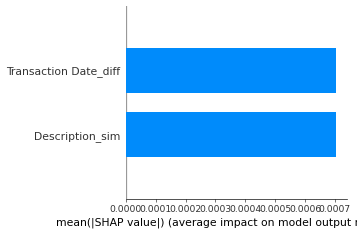


(B) SHAP Dependence Plot for feature: Transaction Date_diff


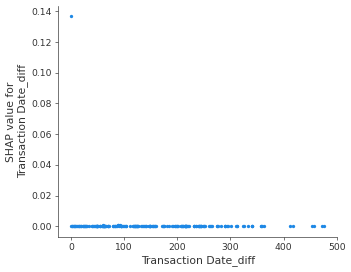


(C) SHAP Waterfall Plot for sample index 0:


ValueError: Image size of 436691x177 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 480x150 with 3 Axes>


(D) SHAP Decision Plot:


ValueError: operands could not be broadcast together with shapes (200,) (200,2) 

In [68]:
import shap
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import matplotlib as mpl
# Reduce DPI so images render smaller
mpl.rcParams['figure.dpi'] = 60

button_shap = widgets.Button(description="Compute SHAP Explanations")
display(button_shap)

def on_button_shap_clicked(b):
    # 1) Ensure we have 'pairs' with 'label'
    if pairs is None:
        print("No 'pairs' DataFrame. Please create and label it first.")
        return
    if 'label' not in pairs.columns:
        print("No 'label' column found in 'pairs'. Please run the labeling step.")
        return

    # 2) Identify numeric feature columns
    feature_cols = [
        col for col in pairs.columns
        if (col.endswith('_diff') or col.endswith('_sim'))
        and pd.api.types.is_numeric_dtype(pairs[col])
    ]
    if not feature_cols:
        print("No numeric feature columns found for SHAP.")
        return

    X = pairs[feature_cols]
    y = pairs['label'].astype(int)

    # 3) Use previously stored globals if available; else train a new model
    try:
        X_train, X_test, y_train, y_test = X_train_global, X_test_global, y_train_global, y_test_global
        model = trained_model
    except NameError:
        print("No global model found. Re-splitting and training a new model.")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

    # Evaluate
    score = model.score(X_test, y_test)
    print(f"Trained RandomForest. Test accuracy: {score:.3f}")

    # 4) Create SHAP explainer
    explainer = shap.Explainer(model, X_train, feature_names=list(X_train.columns))
    shap_values = explainer(X_test)

    # 5) For multi-output, pick class 1
    if len(shap_values.values.shape) == 3:
        shap_values_to_plot = shap.Explanation(
            values       = shap_values.values[:, 1, :],
            base_values  = (shap_values.base_values[:, 1]
                            if shap_values.base_values is not None else None),
            data         = X_test.values,
            feature_names= list(X_test.columns)
        )
    else:
        shap_values_to_plot = shap_values

    # Handle mismatch in shapes between .values and .data
    if shap_values_to_plot.data.shape[1] != shap_values_to_plot.values.shape[1]:
        n_cols = min(shap_values_to_plot.data.shape[1], shap_values_to_plot.values.shape[1])
        shap_values_to_plot = shap.Explanation(
            values       = shap_values_to_plot.values[:, :n_cols],
            base_values  = shap_values_to_plot.base_values,
            data         = shap_values_to_plot.data[:, :n_cols],
            feature_names= shap_values_to_plot.feature_names[:n_cols]
        )

    # If there's an extra offset column
    if shap_values_to_plot.values.shape[1] == shap_values_to_plot.data.shape[1] + 1:
        print("Dropping extra offset column from SHAP values.")
        shap_values_to_plot = shap.Explanation(
            values       = shap_values_to_plot.values[:, :-1],
            base_values  = shap_values_to_plot.base_values,
            data         = shap_values_to_plot.data,
            feature_names= shap_values_to_plot.feature_names[:-1]
        )

    # 6) Down-sample to avoid giant figures
    max_points = 200  # more aggressive down-sample
    n_samples = shap_values_to_plot.values.shape[0]
    if n_samples > max_points:
        print(f"Down-sampling from {n_samples} to {max_points} for plotting.")
        idx = np.random.choice(n_samples, size=max_points, replace=False)
        shap_values_to_plot = shap_values_to_plot[idx]

    # Print shapes
    print("shap_values_to_plot.values.shape:", shap_values_to_plot.values.shape)
    print("shap_values_to_plot.data.shape:", shap_values_to_plot.data.shape)
    print("Feature names:", shap_values_to_plot.feature_names)

    # 7) SHAP Visualizations

    # (A) Summary Plot (bar style) to avoid wide dot swarms
    print("\n(A) SHAP Summary Plot (bar):")
    shap.summary_plot(
        shap_values_to_plot.values,
        shap_values_to_plot.data,
        feature_names=shap_values_to_plot.feature_names,
        max_display=15,        # limit the # of features displayed
        plot_size=(6, 4),      # smaller figure dimension
        plot_type="bar"        # bar plot
    )

    # (B) Dependence Plot for first feature, if available
    if len(shap_values_to_plot.feature_names) > 0:
        feature_to_plot = shap_values_to_plot.feature_names[0]
        print(f"\n(B) SHAP Dependence Plot for feature: {feature_to_plot}")
        shap.dependence_plot(
            feature_to_plot,
            shap_values_to_plot.values,
            shap_values_to_plot.data,
            feature_names=shap_values_to_plot.feature_names,
            interaction_index=None
        )

    # (C) Waterfall Plot for sample 0
    if shap_values_to_plot.values.shape[0] > 0:
        print("\n(C) SHAP Waterfall Plot for sample index 0:")
        shap.waterfall_plot(shap_values_to_plot[0])

    # (D) Decision Plot
    if shap_values_to_plot.values.shape[0] > 0:
        print("\n(D) SHAP Decision Plot:")
        shap.decision_plot(
            shap_values_to_plot.base_values,
            shap_values_to_plot.values,
            shap_values_to_plot.data,
            feature_names=shap_values_to_plot.feature_names
        )

button_shap.on_click(on_button_shap_clicked)
